In [1]:
import warnings
import numba


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=numba.NumbaDeprecationWarning)


import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import utils
import umap
from functools import partial
from tqdm import trange

# Hyperparameters

In [2]:
n_epochs_1d = 10000
n_neighbors_frac = 0.5
max_dim = 6
n_reference = 40
n_nearest_frac = 0.25
threshold = 0.01

In [3]:
def apply_algorithm(name, plot_trajectories, show_embedding, get_params=lambda x: x):
    # read the data
    data_npz = np.load(f"data/{name}.npz")
    raw_data = data_npz["data"] # raw_data is a np.ndarray of shape (n_trajectories, trajectory_length, state_length)
    params = data_npz["params"] # conserved quantities computed theoretically
    data = StandardScaler().fit_transform(np.concatenate(list(raw_data))).reshape(raw_data.shape)

    # show the data
    print("raw data")
    plot_trajectories(raw_data)
    print("normalized data")
    plot_trajectories(data)

    # compute Wasserstein distances
    print("Computing Wasserstein distances...")
    dmat = utils.gen_dist_matrix(data)

    # show Wasserstein distance matrix
    plt.matshow(dmat)
    plt.title("Wasserstein distance matrix")
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel("index #1")
    plt.ylabel("index #2")
    plt.colorbar()
    plt.show()

    # compute UMAP embeddings
    print("Computing embeddings...")
    embeddings = []

    UMAP = partial(umap.UMAP, n_neighbors=int(n_neighbors_frac * len(dmat)), metric="precomputed")

    periodic_embedding = UMAP(n_components=1,
                            output_metric=utils.circle_metric,
                            n_epochs=n_epochs_1d).fit_transform(dmat)
    periodic_embedding = np.vectorize(utils.normalize_angle)(periodic_embedding)
    embeddings.append(periodic_embedding)

    for n_components in trange(1, max_dim + 1):
        if n_components == 1:
            embedding = UMAP(n_components=n_components, n_epochs=n_epochs_1d).fit_transform(dmat)
        else:
            embedding = UMAP(n_components=n_components).fit_transform(dmat)
        embeddings.append(embedding)

    # compute scores
    order_score = utils.OrderScore(dmat, n_reference, int(n_nearest_frac * len(dmat)))

    scores = []
    errors = []

    score, error = order_score.order_score(embeddings[0], output_metric=utils.circle_metric_without_grad)
    scores.append(score)
    errors.append(error)

    for embedding in embeddings[1:]:
        score, error = order_score.order_score(embedding)
        scores.append(score)
        errors.append(error)

    # show scores and score differences
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    predicted_n_conserved = utils.get_stop_point(scores, threshold)
    print(f"predicted number of conservation laws: {predicted_n_conserved}")

    utils.plot_scores(ax1, scores, errors)
    utils.plot_score_diffs(ax2, scores, errors, predicted_n_conserved, threshold)
    plt.show()

    # show embeddings
    show_embedding(embeddings, get_params(params))


def show_embedding_1d(embeddings, params, quantity_name="energy"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    utils.plot_1d(fig, ax1, embeddings[1], *params.T, quantity_name)
    utils.plot_embedding_vs_conserved_quantity(ax2, embeddings[1], *params.T, quantity_name)


def show_embedding_1d_periodic(embeddings, params, quantity_name="spatial phase"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    utils.plot_periodic_1d(fig, ax1, embeddings[0], *params.T, quantity_name)
    utils.plot_embedding_vs_conserved_quantity(ax2, embeddings[1], *params.T, quantity_name)


def show_embedding_2d(embeddings, params, quantity_names=["energy1", "energy2"]):
    utils.plot_all_2d(*plt.subplots(1, 2, figsize=(15, 5)), embeddings[2], params, quantity_names)


def show_embedding_3d(embeddings, params, quantity_names=["energy", "angular momentum", "orientation angle"]):
    utils.plot_all_3d(*plt.subplots(3, 3, figsize=(15, 15)), embeddings[3], params, quantity_names)


plt.rcParams.update({'font.size': 10})


# Harmonic oscillator

raw data


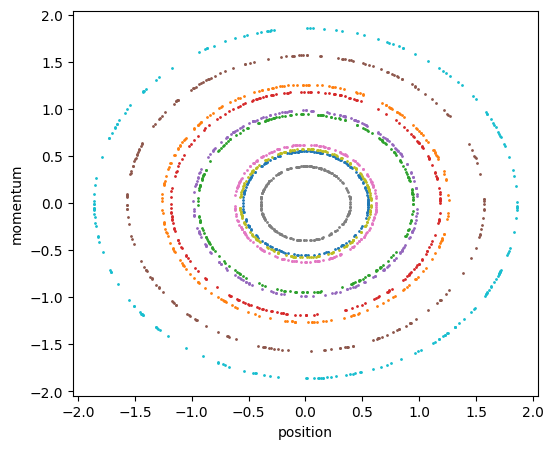

normalized data


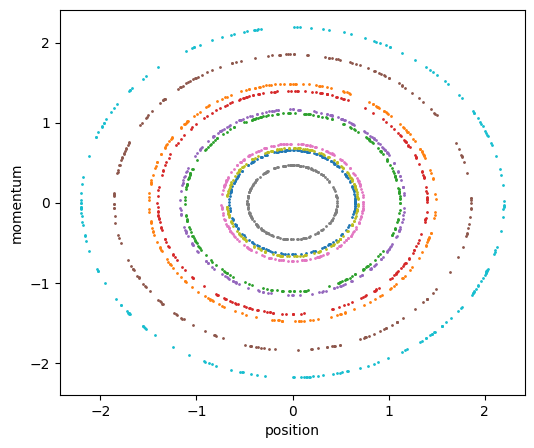

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0010s
   1990 / 19900  EMDs computed  -  10.00% completed - 1.396s
   3980 / 19900  EMDs computed  -  20.00% completed - 2.795s
   5970 / 19900  EMDs computed  -  30.00% completed - 4.088s
   7960 / 19900  EMDs computed  -  40.00% completed - 5.485s
   9950 / 19900  EMDs computed  -  50.00% completed - 6.798s
  11940 / 19900  EMDs computed  -  60.00% completed - 8.119s
  13930 / 19900  EMDs computed  -  70.00% completed - 9.495s
  15920 / 19900  EMDs computed  -  80.00% completed - 10.834s
  17910 / 19900  EMDs computed  -  90.00% completed - 12.206s
  19900 / 19900  EMDs computed  - 100.00% completed - 13.616s


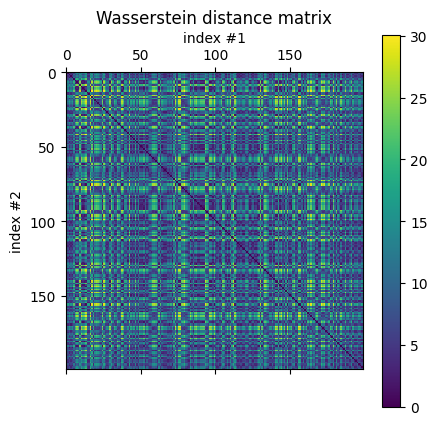

Computing embeddings...


100%|██████████| 6/6 [01:50<00:00, 18.46s/it]


predicted number of conservation laws: 1


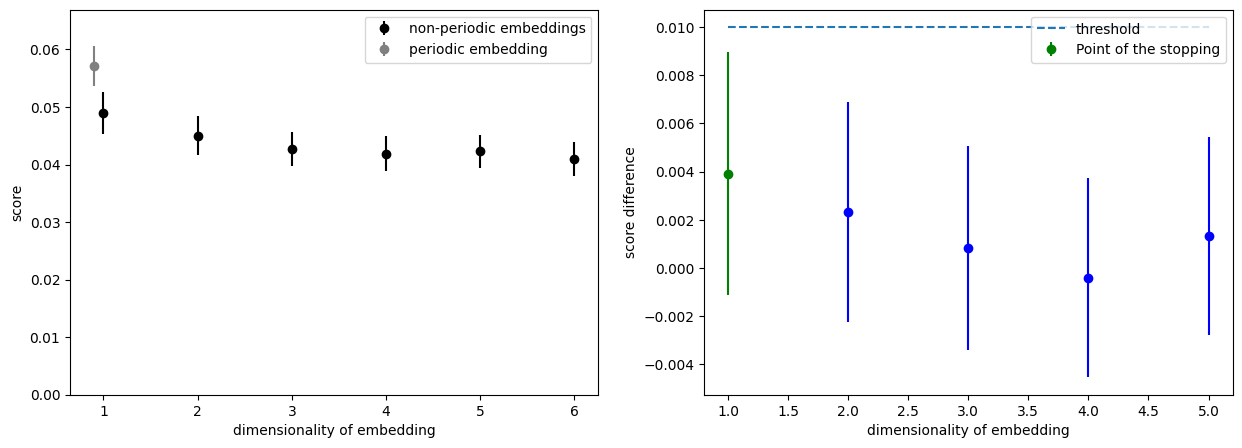

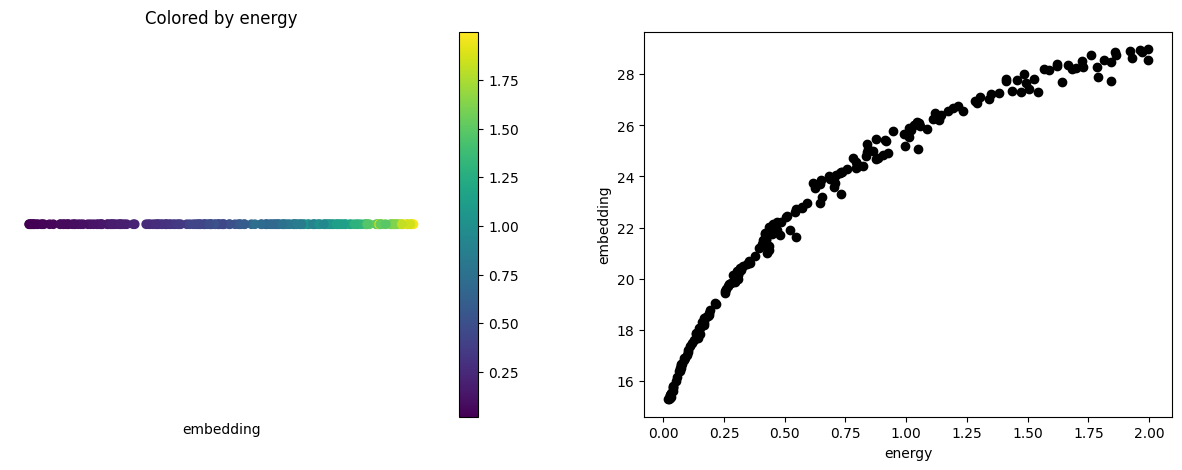

In [4]:
def plot_trajectories_ho(data, N_traj=10):
    plt.figure(figsize=(6, 5))
    for traj in data[:N_traj]:
        plt.scatter(*traj.T, s=1)
    plt.xlabel("position")
    plt.ylabel("momentum")
    plt.show()


apply_algorithm("harmonic_oscillator", plot_trajectories_ho, show_embedding_1d)

# Double pendulum

In [5]:
def plot_trajectories_dp(data, N_traj=3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, ax in enumerate(axes):
        for traj in data[range(N_traj)]:
            ax.scatter(*traj[:, [2 * i, 2 * i + 1]].T)
        ax.set_xlabel("$\\theta_" + str(i + 1) + "$")
        ax.set_ylabel("$\\frac{\\mathrm{d}\\theta_" + str(i + 1) + "}{\\mathrm{d}t}$")

    plt.show()

## Low energy

raw data


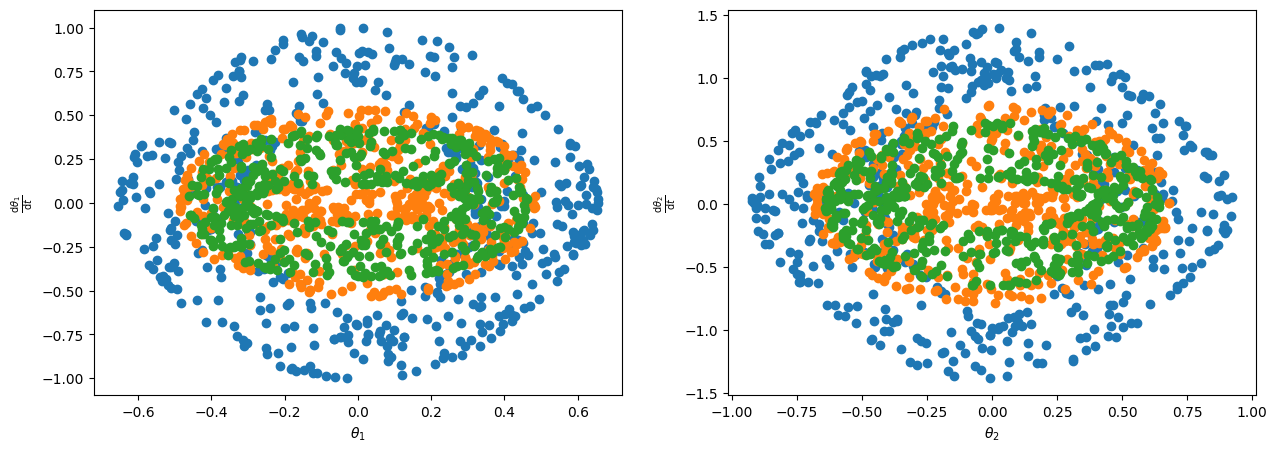

normalized data


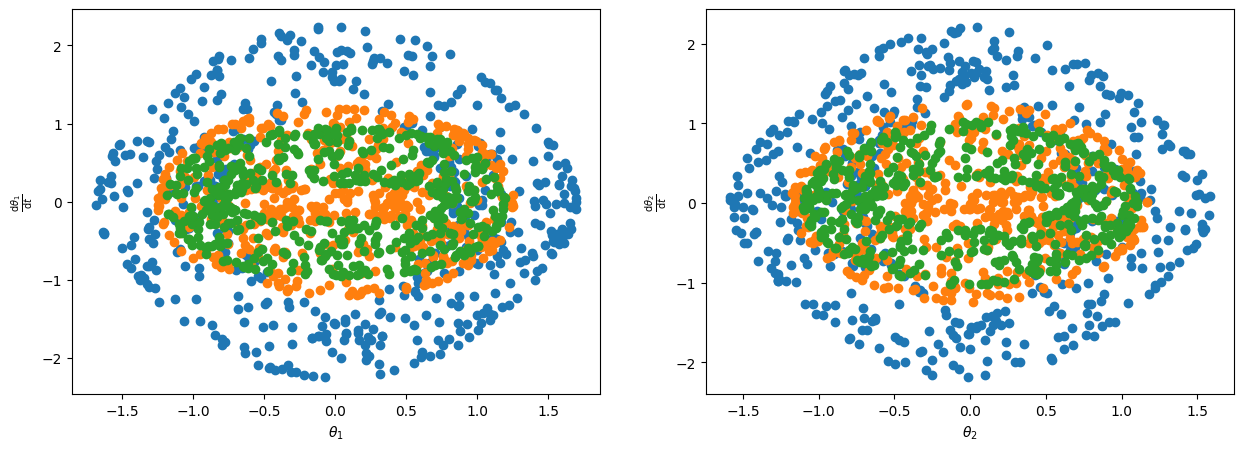

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0019s
   1990 / 19900  EMDs computed  -  10.00% completed - 3.846s
   3980 / 19900  EMDs computed  -  20.00% completed - 7.750s
   5970 / 19900  EMDs computed  -  30.00% completed - 11.626s
   7960 / 19900  EMDs computed  -  40.00% completed - 15.630s
   9950 / 19900  EMDs computed  -  50.00% completed - 19.535s
  11940 / 19900  EMDs computed  -  60.00% completed - 23.398s
  13930 / 19900  EMDs computed  -  70.00% completed - 27.370s
  15920 / 19900  EMDs computed  -  80.00% completed - 31.289s
  17910 / 19900  EMDs computed  -  90.00% completed - 35.235s
  19900 / 19900  EMDs computed  - 100.00% completed - 39.122s


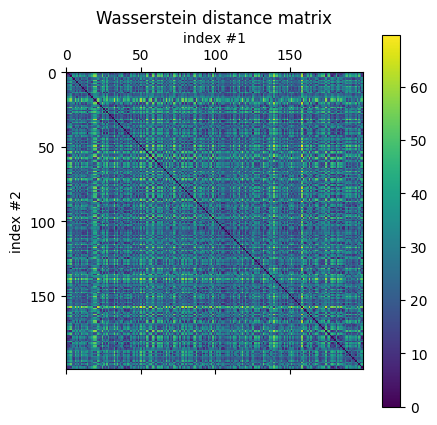

Computing embeddings...


100%|██████████| 6/6 [01:58<00:00, 19.74s/it]


predicted number of conservation laws: 2


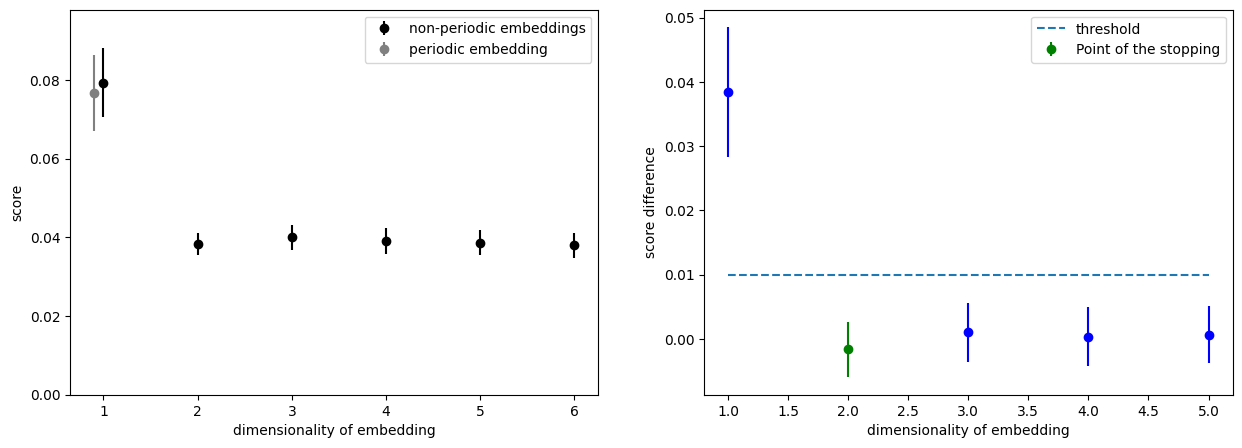

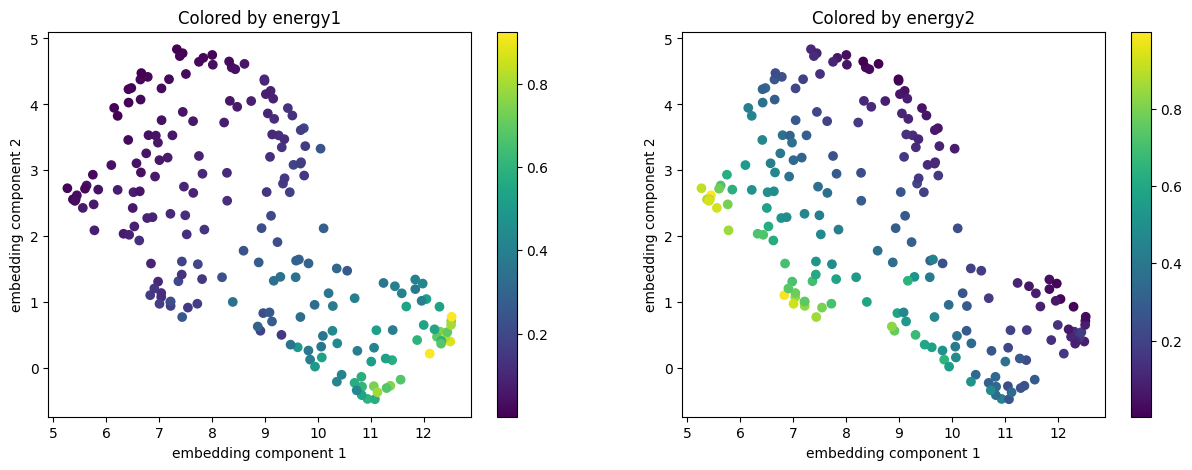

In [6]:
apply_algorithm("double_pendulum_low_energy", plot_trajectories_dp, show_embedding_2d,lambda params: params[:, [1, 2]])

## High energy

raw data


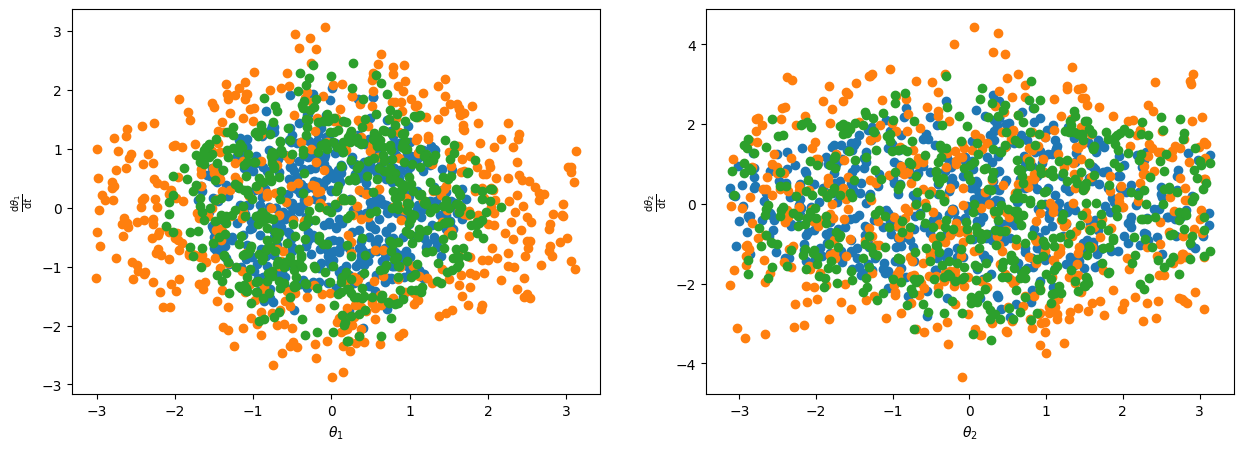

normalized data


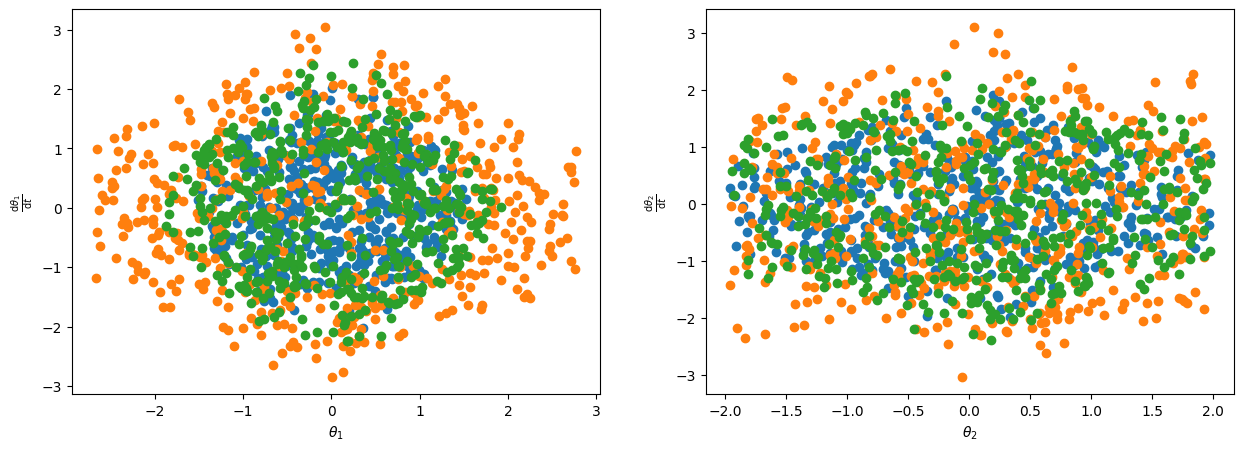

Computing Wasserstein distances...
Finished preprocessing 400 events in 0.0039s
   7980 / 79800  EMDs computed  -  10.00% completed - 16.223s
  15960 / 79800  EMDs computed  -  20.00% completed - 32.363s
  23940 / 79800  EMDs computed  -  30.00% completed - 48.317s
  31920 / 79800  EMDs computed  -  40.00% completed - 64.277s
  39900 / 79800  EMDs computed  -  50.00% completed - 80.392s
  47880 / 79800  EMDs computed  -  60.00% completed - 96.379s
  55860 / 79800  EMDs computed  -  70.00% completed - 112.448s
  63840 / 79800  EMDs computed  -  80.00% completed - 128.430s
  71820 / 79800  EMDs computed  -  90.00% completed - 144.254s
  79800 / 79800  EMDs computed  - 100.00% completed - 160.206s


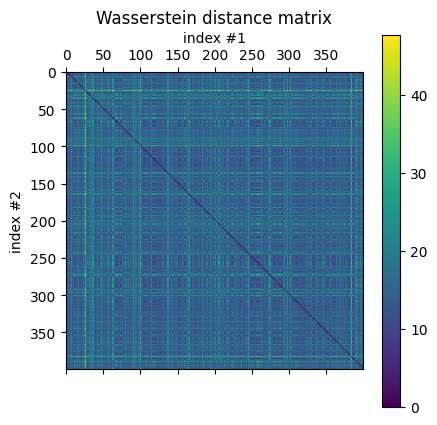

Computing embeddings...


100%|██████████| 6/6 [03:09<00:00, 31.66s/it] 


predicted number of conservation laws: 1


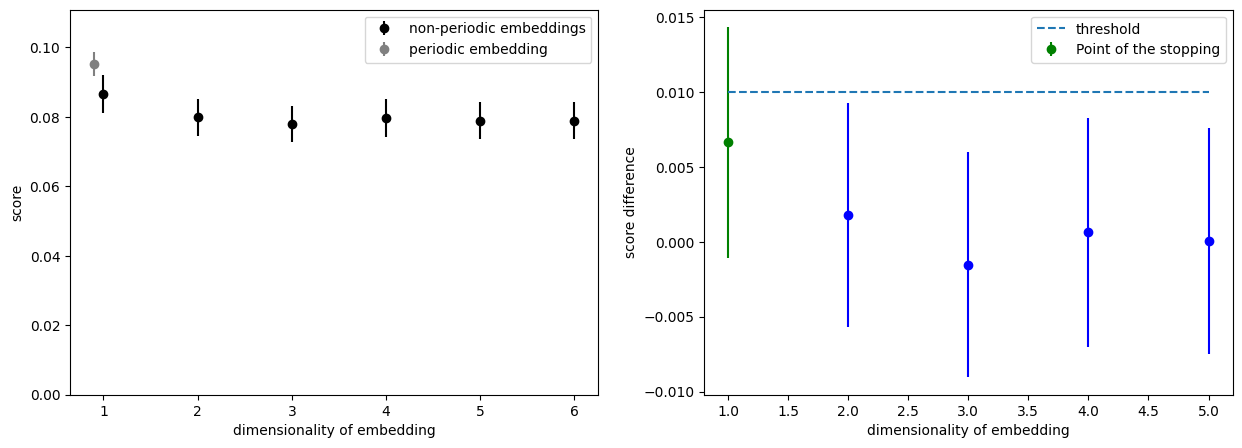

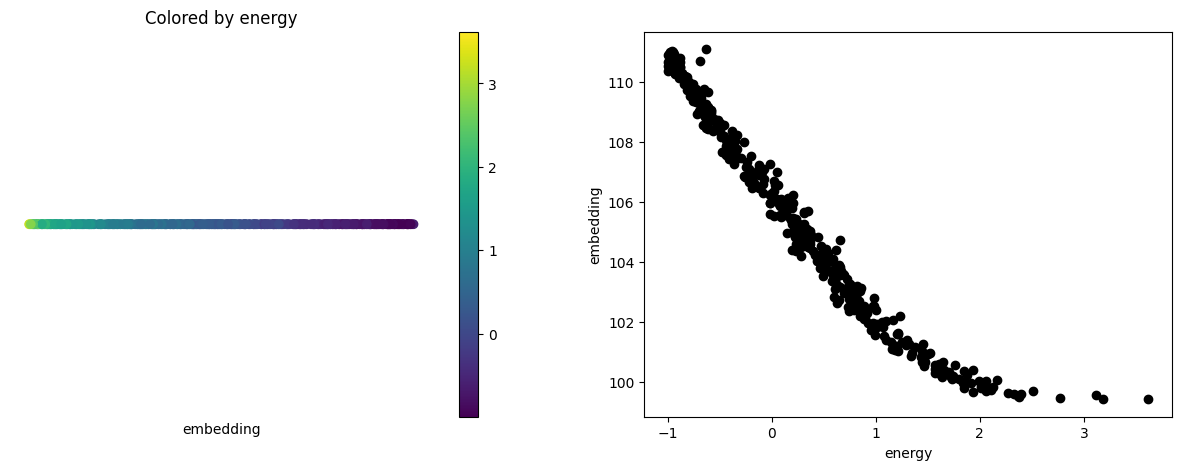

In [7]:
apply_algorithm("double_pendulum_high_energy", plot_trajectories_dp, show_embedding_1d, lambda params: params[:, :1])

# Kepler problem

In [8]:
def plot_trajectories_kp(data, N_traj=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for traj in data[:N_traj]:
        ax1.scatter(*traj.T[:2], s=1)
    ax1.set_xlabel("$x_1$")
    ax1.set_ylabel("$x_2$")

    for traj in data[:N_traj]:
        ax2.scatter(*traj.T[2:], s=1)
    ax2.set_xlabel("$\\frac{\\mathrm{d}x_1}{\\mathrm{d}t}$")
    ax2.set_ylabel("$\\frac{\\mathrm{d}x_2}{\\mathrm{d}t}$")

    plt.show()

raw data


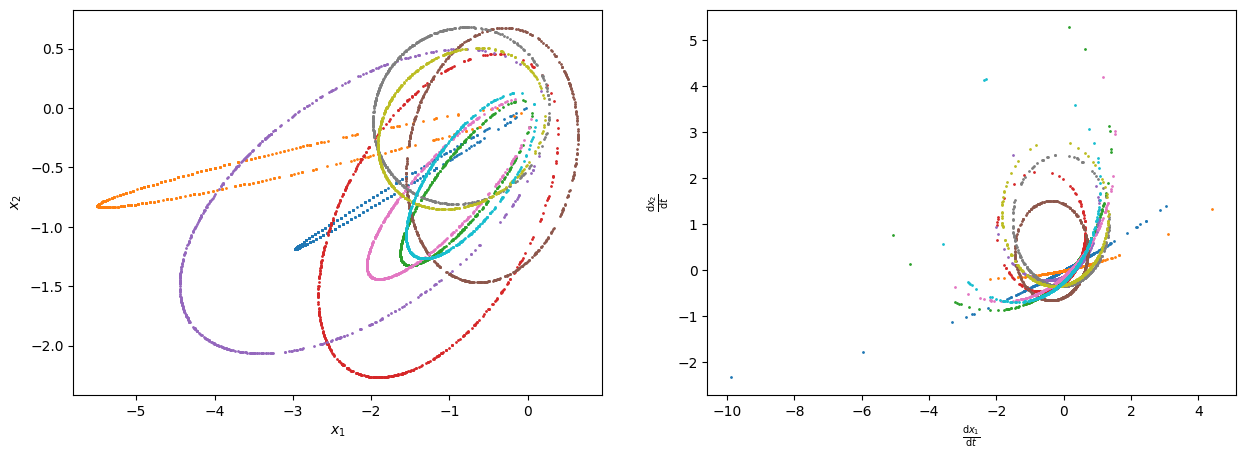

normalized data


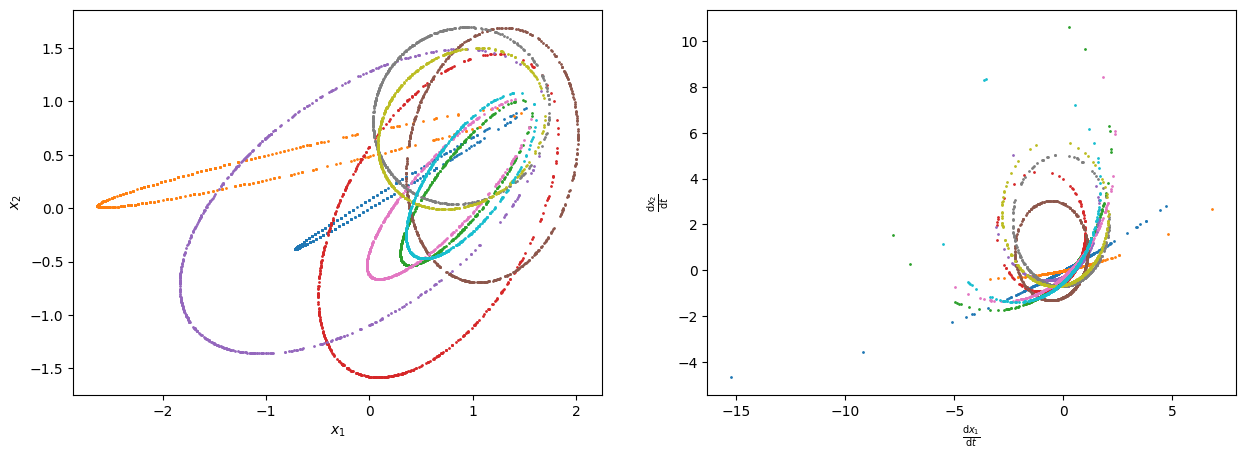

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0020s


PairwiseEMD::compute - Issue with EMD between events (192, 11), error code 4
PairwiseEMD::compute - Issue with EMD between events (193, 143), error code 4


   1990 / 19900  EMDs computed  -  10.00% completed - 14.753s
   3980 / 19900  EMDs computed  -  20.00% completed - 19.805s


PairwiseEMD::compute - Issue with EMD between events (176, 154), error code 4
PairwiseEMD::compute - Issue with EMD between events (173, 162), error code 4
PairwiseEMD::compute - Issue with EMD between events (172, 118), error code 4
PairwiseEMD::compute - Issue with EMD between events (173, 141), error code 4


   5970 / 19900  EMDs computed  -  30.00% completed - 35.920s


PairwiseEMD::compute - Issue with EMD between events (40, 30), error code 4


   7960 / 19900  EMDs computed  -  40.00% completed - 51.709s


PairwiseEMD::compute - Issue with EMD between events (159, 52), error code 4
PairwiseEMD::compute - Issue with EMD between events (152, 0), error code 4
PairwiseEMD::compute - Issue with EMD between events (43, 30), error code 4


   9950 / 19900  EMDs computed  -  50.00% completed - 64.919s


PairwiseEMD::compute - Issue with EMD between events (147, 86), error code 4


  11940 / 19900  EMDs computed  -  60.00% completed - 80.294s


PairwiseEMD::compute - Issue with EMD between events (64, 56), error code 4


  13930 / 19900  EMDs computed  -  70.00% completed - 91.552s


PairwiseEMD::compute - Issue with EMD between events (126, 22), error code 4


  15920 / 19900  EMDs computed  -  80.00% completed - 97.324s


PairwiseEMD::compute - Issue with EMD between events (116, 72), error code 4


  17910 / 19900  EMDs computed  -  90.00% completed - 112.403s


PairwiseEMD::compute - Issue with EMD between events (109, 32), error code 4
PairwiseEMD::compute - Issue with EMD between events (92, 20), error code 4


  19900 / 19900  EMDs computed  - 100.00% completed - 130.929s


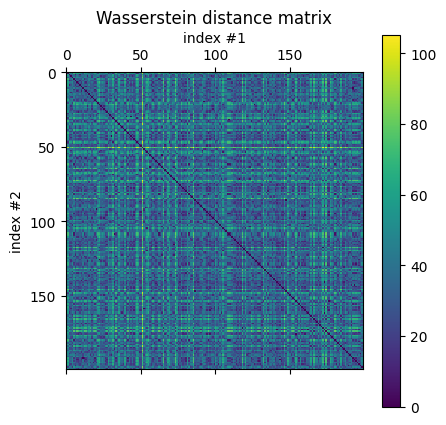

Computing embeddings...


100%|██████████| 6/6 [01:45<00:00, 17.66s/it]


predicted number of conservation laws: 3


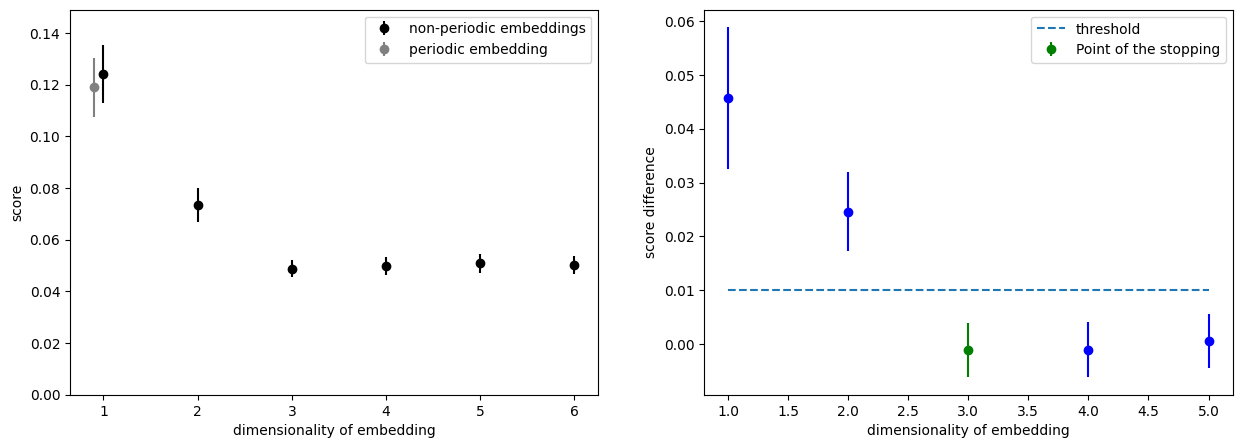

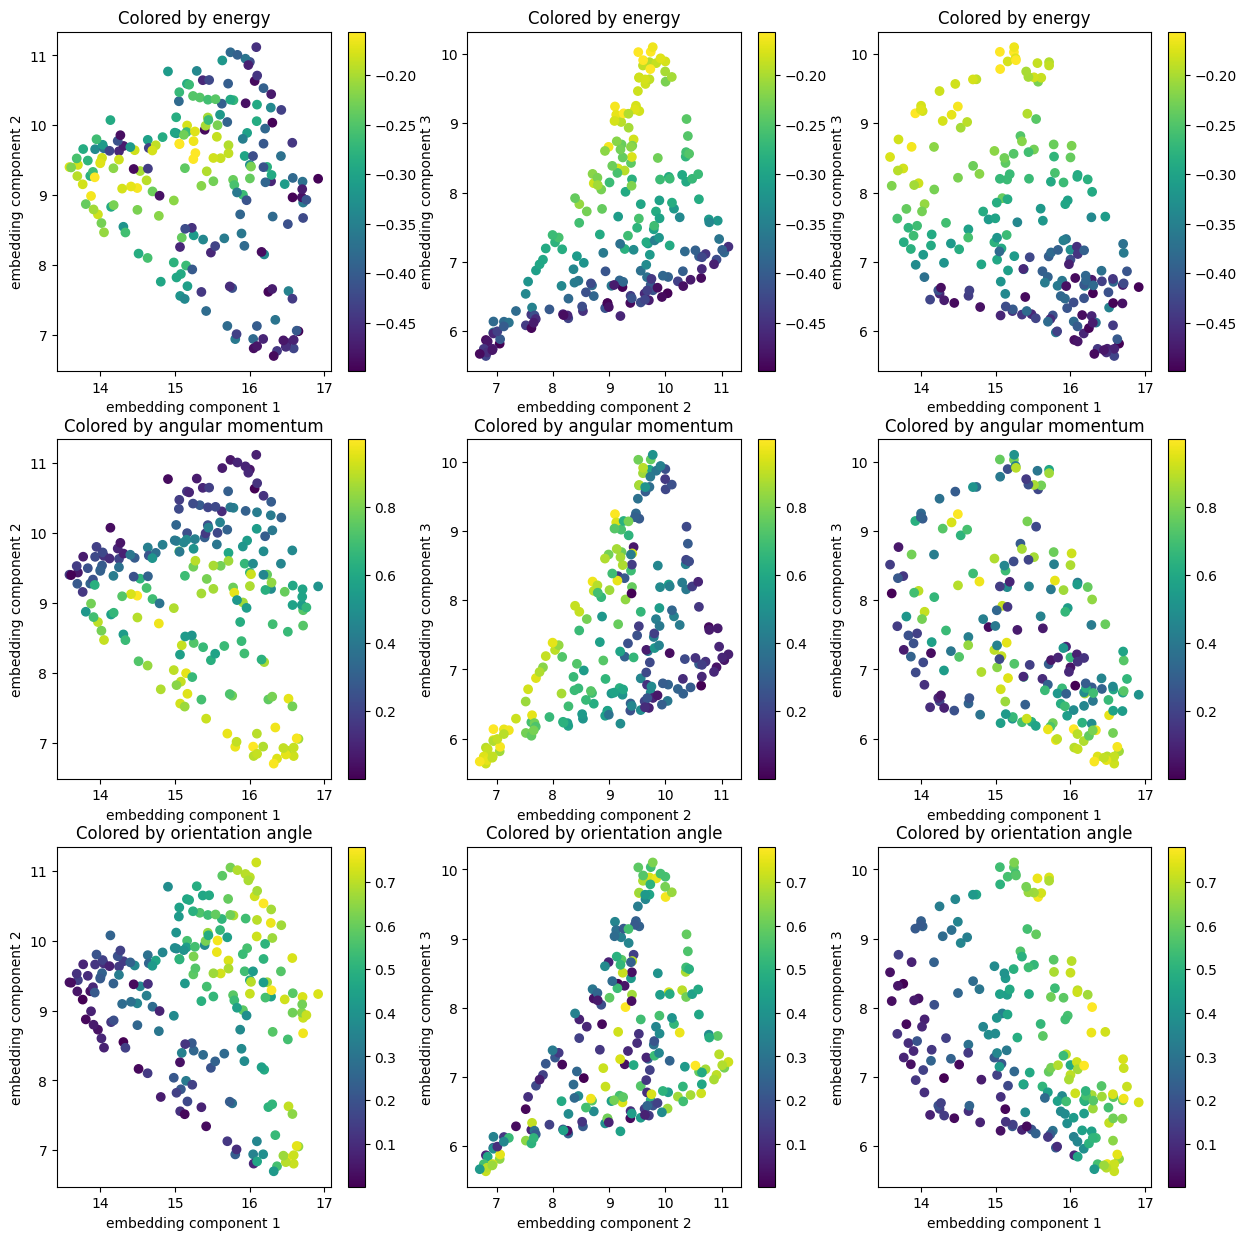

In [9]:
apply_algorithm("kepler_problem", plot_trajectories_kp, show_embedding_3d)

# Oscillating Turing patterns

In [10]:
def plot_trajectories_turing(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, ax in enumerate(axes):
        image = ax.imshow(data[0,:,i::2].T, aspect='auto', origin='lower')
        ax.set_xlabel('Sample Number')
        ax.set_ylabel('$x$')
        ax.set_yticks([0,12.5, 25, 37.5],[0, 2, 4, 6])
        fig.colorbar(image, ax=ax)
        f = "v" if i else "u"
        ax.set_title("$" + "f" + "(x)$")

    plt.show()


raw data


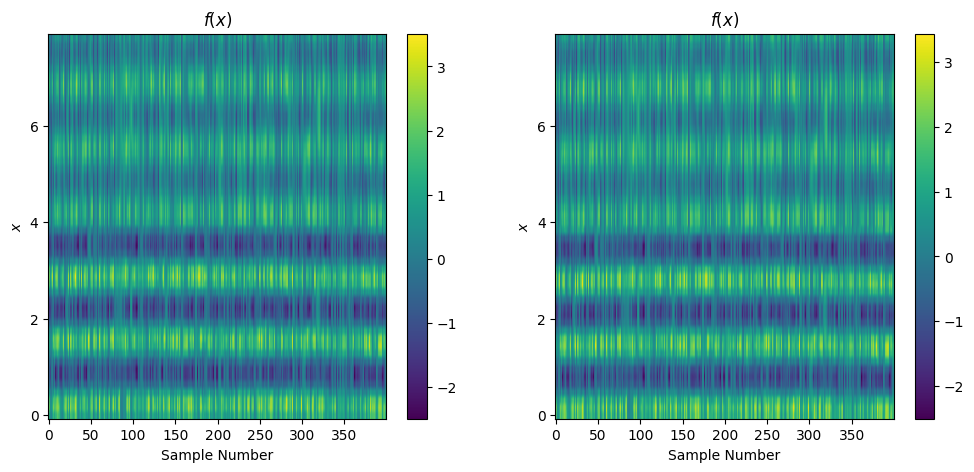

normalized data


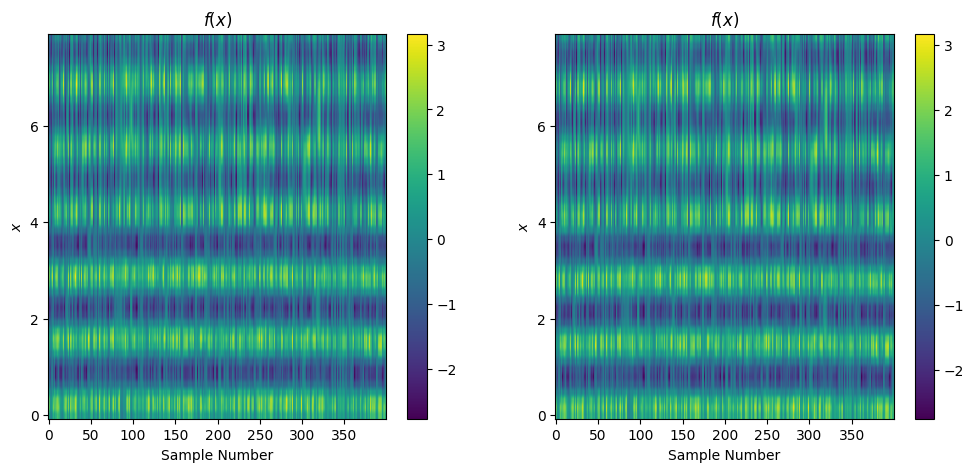

Computing Wasserstein distances...
Finished preprocessing 200 events in 0.0225s
   1990 / 19900  EMDs computed  -  10.00% completed - 4.491s
   3980 / 19900  EMDs computed  -  20.00% completed - 9.007s
   5970 / 19900  EMDs computed  -  30.00% completed - 13.500s
   7960 / 19900  EMDs computed  -  40.00% completed - 17.965s
   9950 / 19900  EMDs computed  -  50.00% completed - 22.523s
  11940 / 19900  EMDs computed  -  60.00% completed - 27.133s
  13930 / 19900  EMDs computed  -  70.00% completed - 31.689s
  15920 / 19900  EMDs computed  -  80.00% completed - 36.268s
  17910 / 19900  EMDs computed  -  90.00% completed - 40.822s
  19900 / 19900  EMDs computed  - 100.00% completed - 45.413s


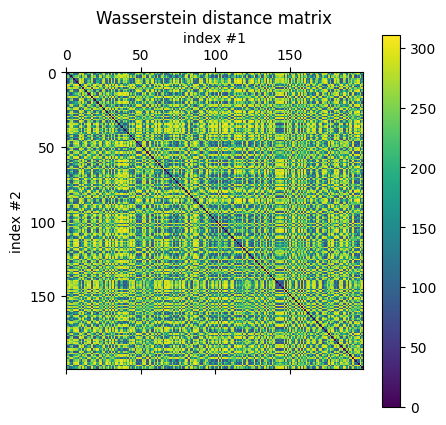

Computing embeddings...


100%|██████████| 6/6 [01:56<00:00, 19.45s/it]


predicted number of conservation laws: 1


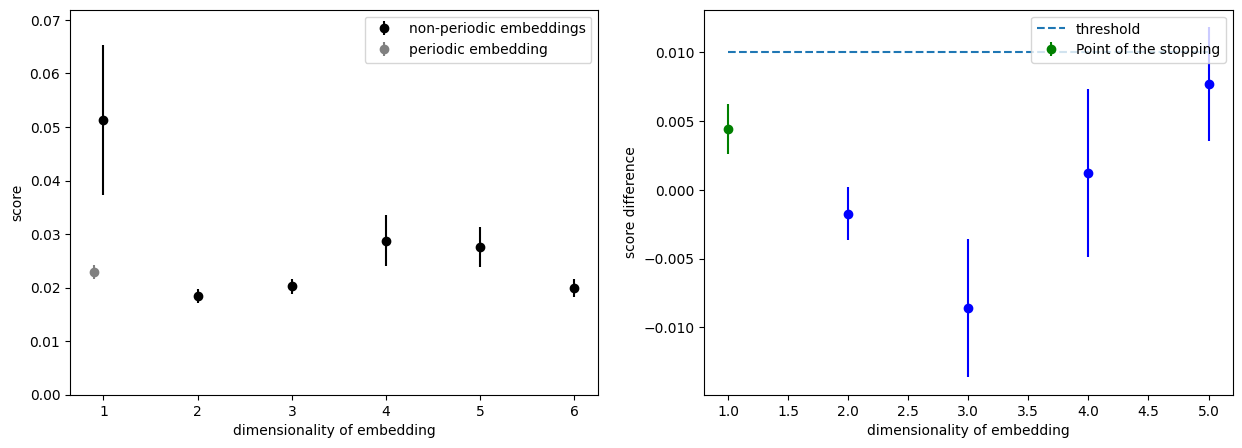

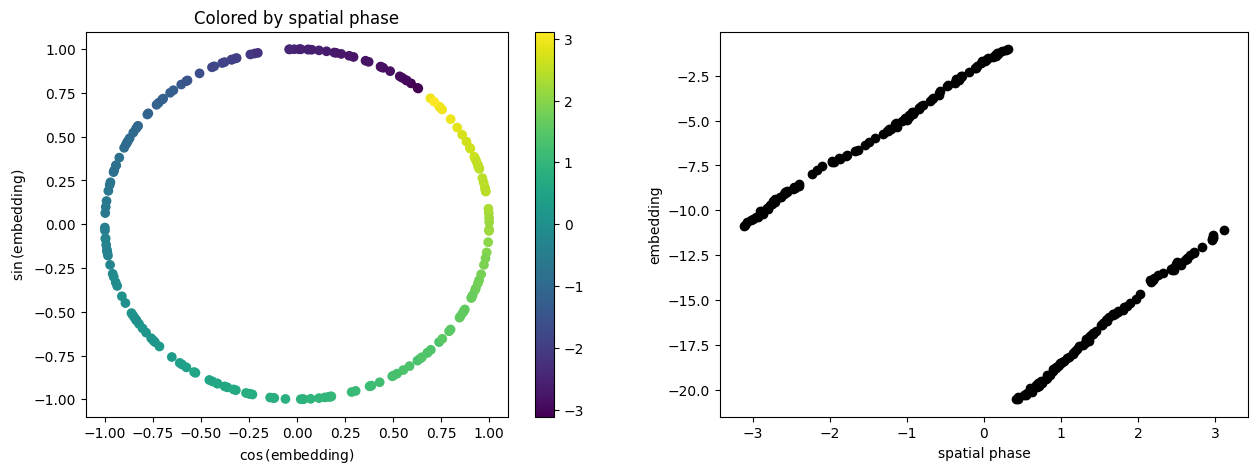

In [11]:
apply_algorithm("turing", plot_trajectories_turing, show_embedding_1d_periodic)